In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(magrittr)
library(here)
library(furrr)
library(scales)
library(lemon)
library(cowplot)

devtools::load_all(".")
})

plan(multiprocess)

Loading ychr


In [49]:
add_mut_rate <- function(counts) {
    mutate(counts, mut_rate = (d - e) / 45000 / total)
}

add_tafr <- function(counts) {
    mutate(counts, tmrca_afr = f / (total * mut_rate))
}

add_tarch_mendez <- function(counts, tafr) {
    mutate(counts, tmrca_mendez = tafr * (2 * a + d + e) / (d + e))
}

add_tarch_new <- function(counts, tafr) {
    mutate(counts, tmrca_new = tafr * (a + d) / d)
}

In [3]:
run_step1 <- function(gt) {
    samples <- if ("simY" %in% gt$chrom) read_siminfo(gt) else read_info(gt)

    refs <- filter(samples, pop != "Africa", pop != "EMH")$name

    map_dfr(refs, ~ sum_patterns(gt, w = "chimp", x = "a00", y = .x, z = "ustishim") %>%
            mutate(ref = .x)) %>%
    select(ref, everything()) %>%
    add_mut_rate %>%
    add_tafr
}

In [4]:
run_step2 <- function(gt, step1) {
    tafr <- select(step1, ref, mut_rate, tmrca_afr)

    samples <- if ("simY" %in% gt$chrom) read_siminfo(gt) else read_info(gt)

    refs <- filter(samples, pop != "Africa", pop != "EMH")$name
    archaic <- colnames(select(gt, -c(chrom, pos, REF, ALT, chimp), -one_of(samples$name)))

    map_dfr(refs, ~ sum_patterns(gt, w = "chimp", x = archaic, y = .x, z = "a00") %>% 
            mutate(arch = archaic, ref = .x)) %>%
    inner_join(tafr, by = "ref") %>%
    add_tarch_mendez %>%
    add_tarch_new %>%
    select(arch, ref, everything())
}

In [5]:
simulate_counts <- function(counts, n = 100000) {
  tibble(
    a = rpois(n, counts$a),
    b = rpois(n, counts$b),
    c = rpois(n, counts$c),
    d = rpois(n, counts$d),
    e = rpois(n, counts$e),
    f = rpois(n, counts$f),
    total = counts$total
  )
}

In [6]:
add_tafr_ci <- function(df) {
    simulate_counts(df) %>%
        add_mut_rate %>%
        add_tafr %>%
    select(tmrca_afr, mut_rate) %>%
    calculate_ci %>%
    bind_cols(df, .) %>%
    select(starts_with("tmrca"), starts_with("mut_rate"), everything())
}

In [46]:
add_tarch_ci <- function(df, tafr) {
    simulate_counts(df) %>% 
    add_tarch_mendez(tafr) %>%
    add_tarch_new(tafr) %>%
    select(tmrca_mendez, tmrca_new) %>%
    calculate_ci %>%
    bind_cols(df, .) %>%
    select(starts_with("tmrca"), starts_with("mut_rate"), everything())
}

In [8]:
calculate_ci <- function(df) {
    df %>%
    gather(stat, value) %>%
    group_by(stat) %>%
    summarise(
        low = quantile(value, 0.025),
        high = quantile(value, 0.975)
    ) %>%
    gather(boundary, value, -stat) %>%
    unite(temp, stat, boundary) %>%
    spread(temp, value)
}

In [9]:
highcov_gt <- read_vcf(here("data/vcf/full_highcov.vcf.gz"), mindp = 3, maxdp = 0.975)

In [10]:
gt <- read_genotypes("mez2", "full", mindp = 3, maxdp = 0.975)

In [11]:
step1 <- run_step1(highcov_gt)

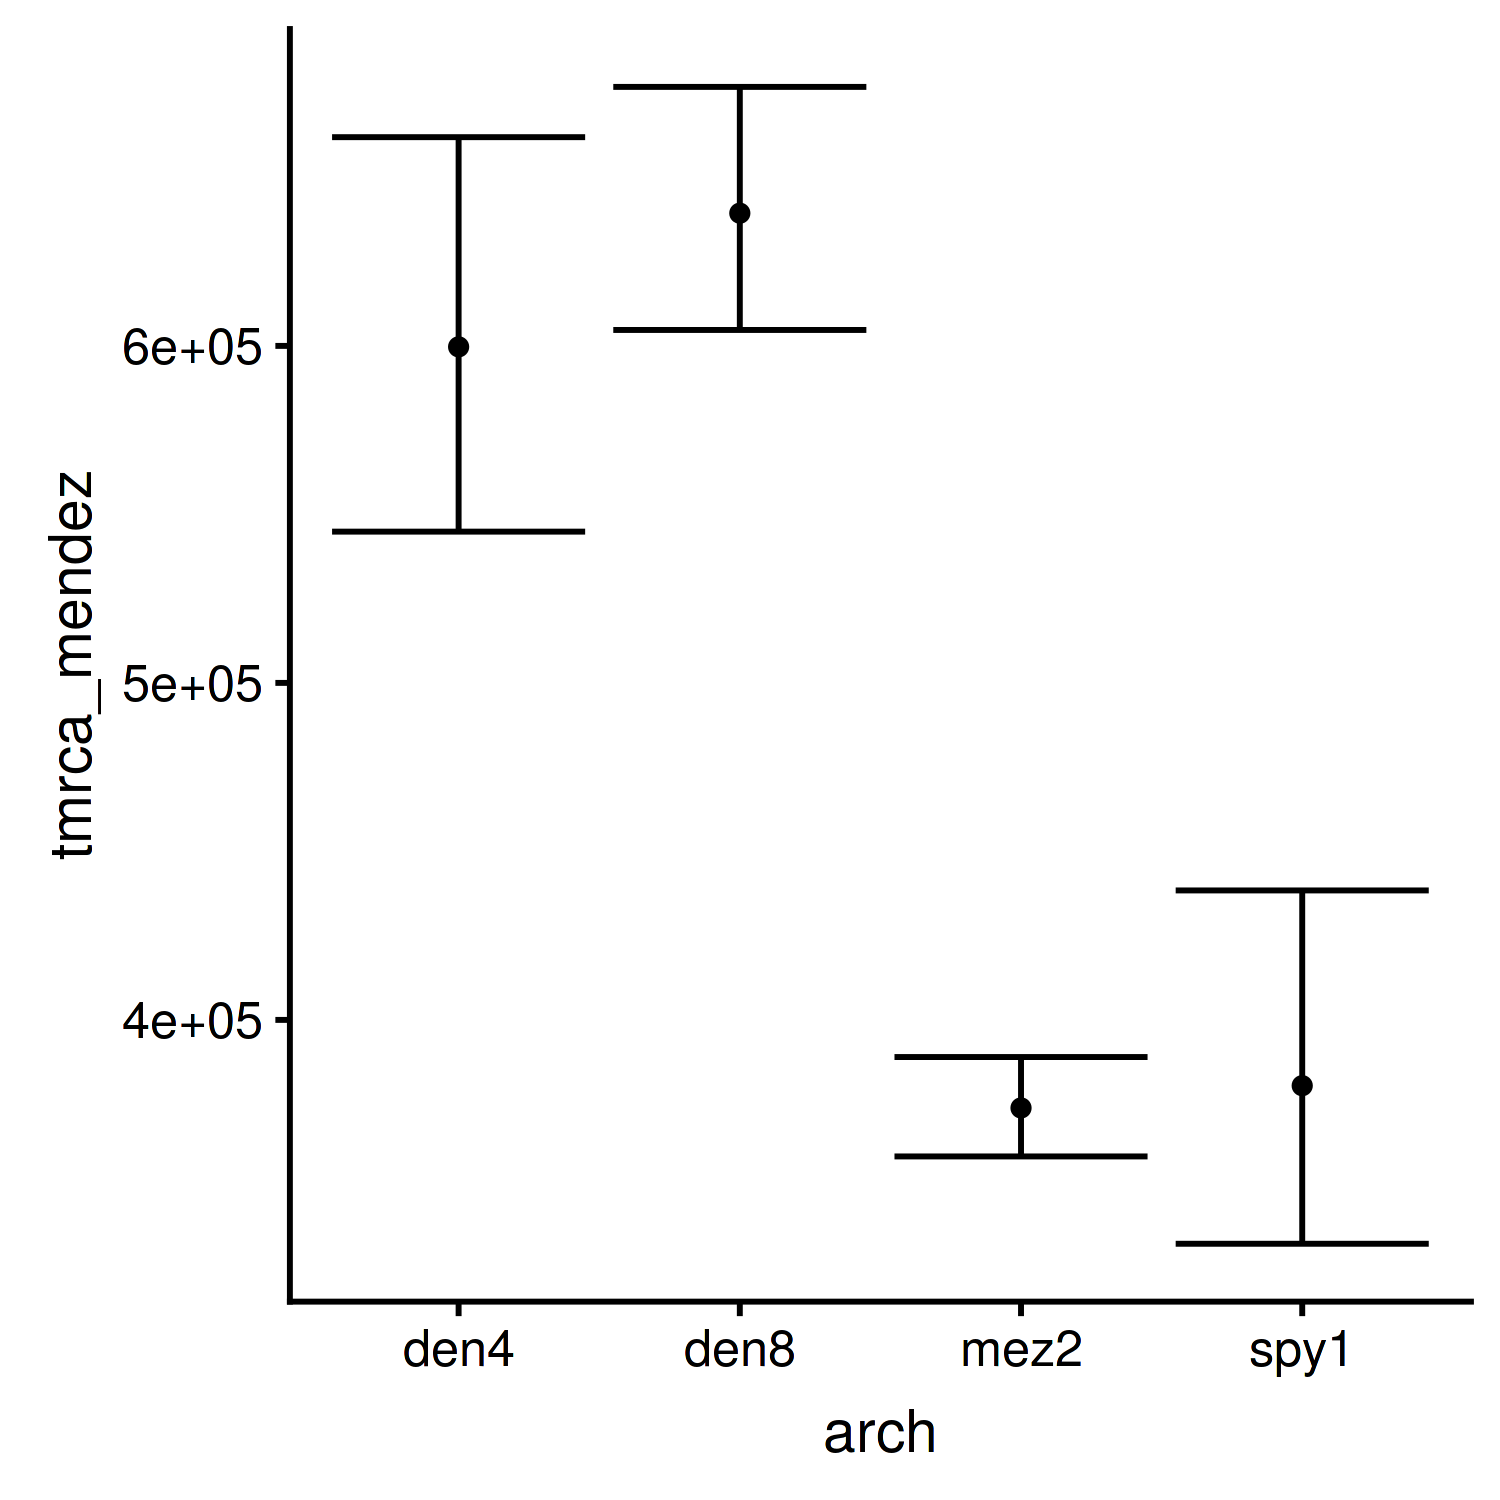

In [53]:
df %>% filter(dp == 3, sites == "all") %>% group_by(arch, sites) %>% summarise_if(is.numeric, mean) %>%
ungroup %>% 
nest(a:total, .key = "counts") %>%
mutate(ci = map2(counts, tmrca_afr, ~ add_tarch_ci(.x, .y))) %>%
unnest(ci) %>%
ggplot(aes(arch, tmrca_mendez)) + geom_point() + geom_errorbar(aes(ymin = tmrca_mendez_low, ymax = tmrca_mendez_high))

In [12]:
df <-
    map_dfr(c("den4", "den8", "mez2", "spy1"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:8, function(dp) {
                gt <- read_genotypes(arch, "full", mindp = dp, maxdp = 0.975, tv_only = sites == "tv_only")
                step2 <- run_step2(gt, step1) %>% mutate(dp = dp, sites = sites)
            })
        })
    }) %>% mutate(capture = "full")

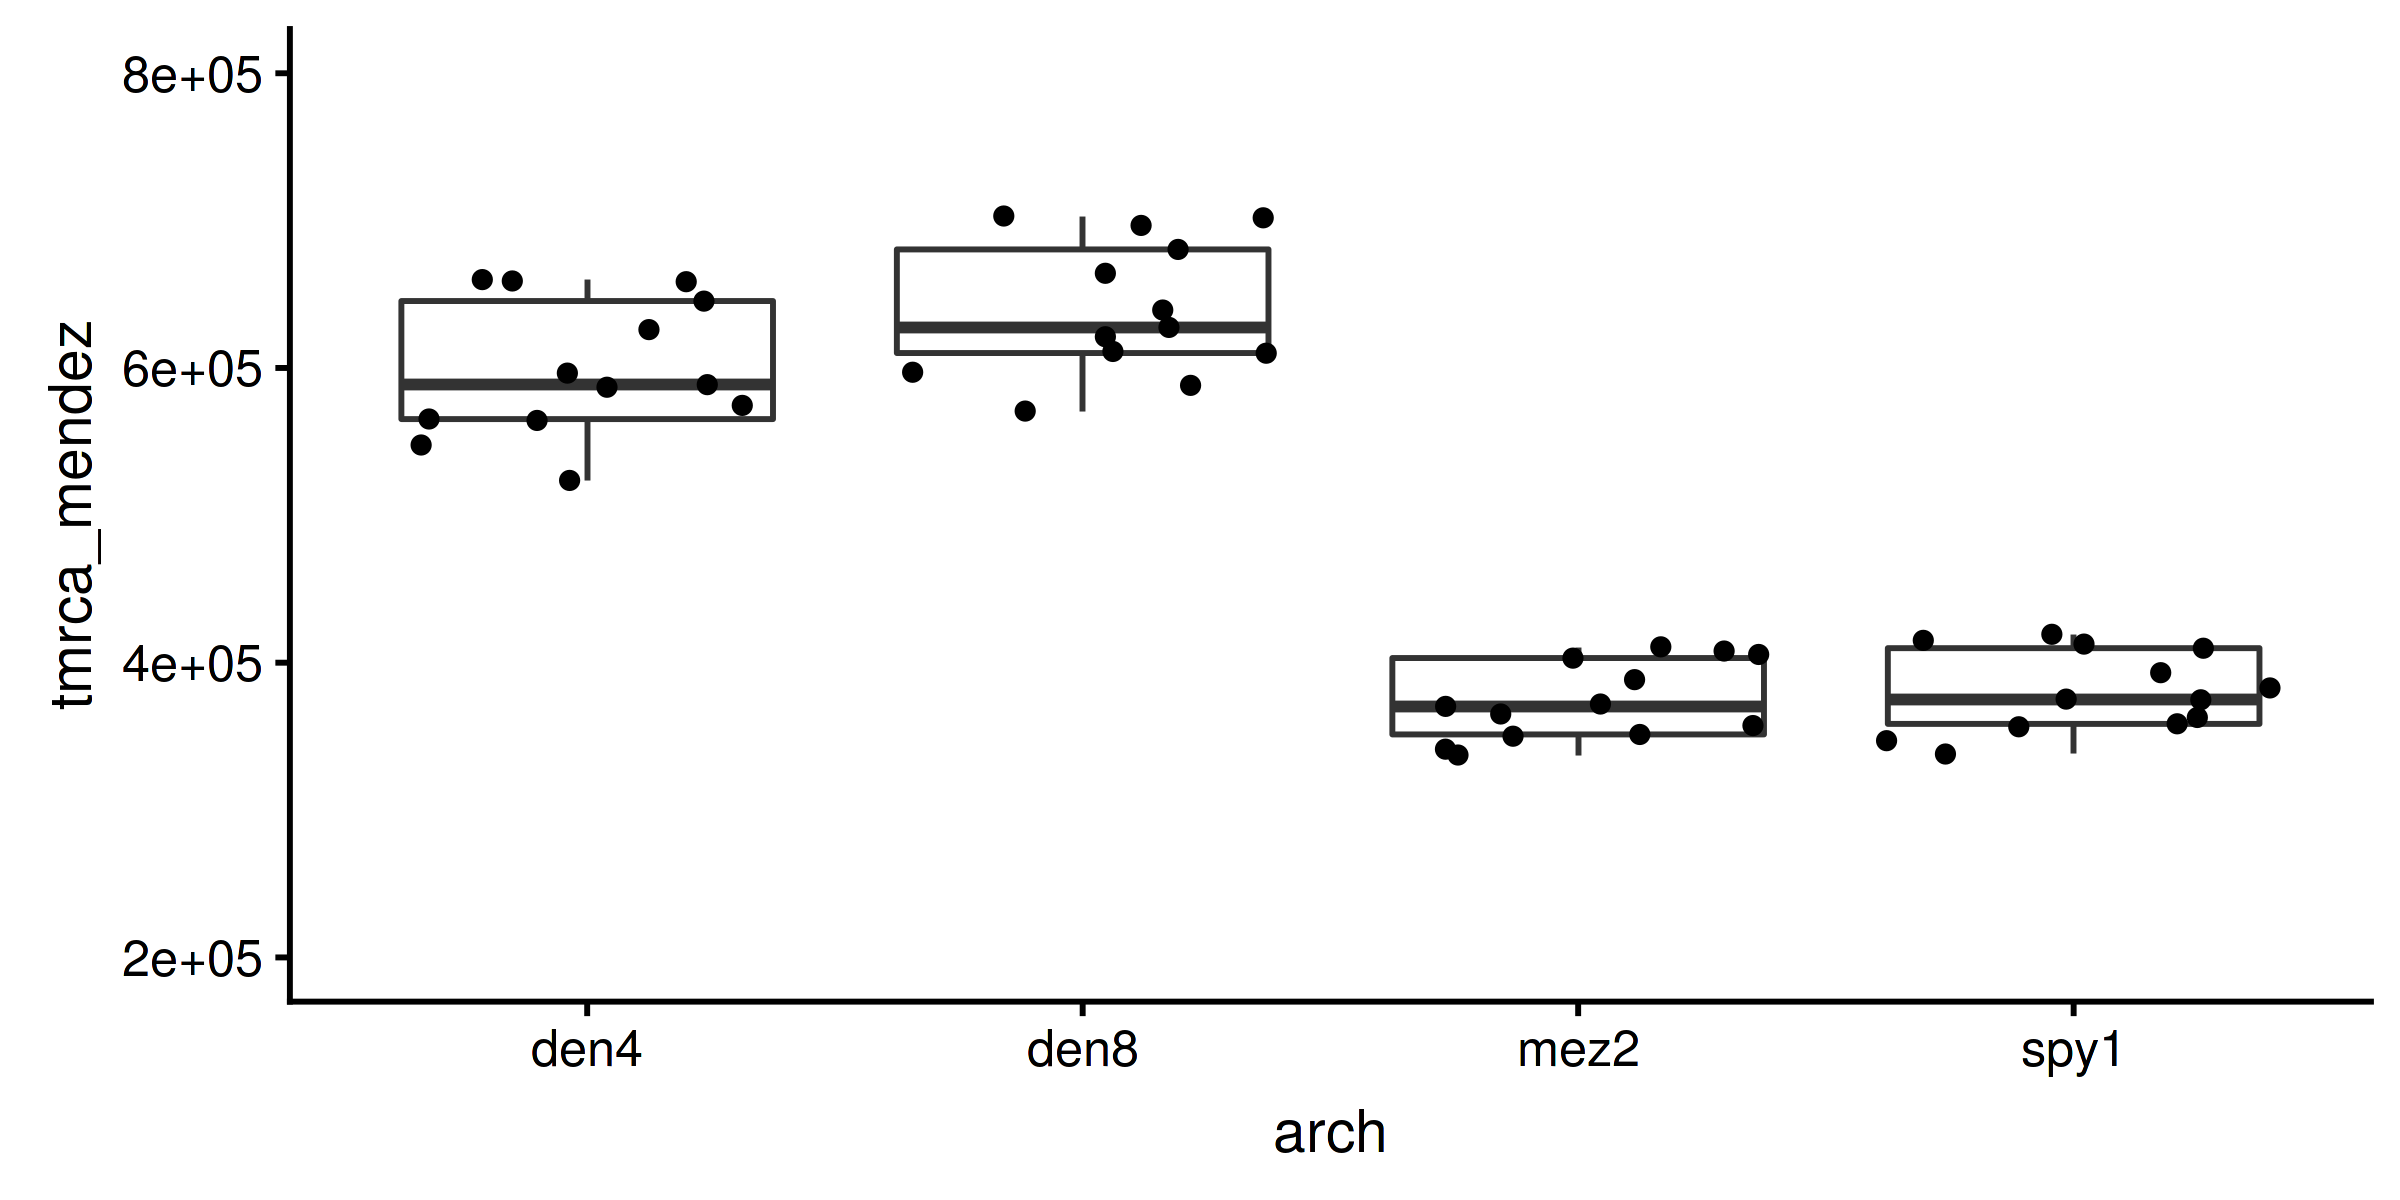

In [13]:
set_dim(8, 4)

df %>% filter(dp == 3, sites == "all") %>%
ggplot(aes(arch, tmrca_mendez)) + geom_boxplot() + geom_jitter() + ylim(200000, 800000)

In [14]:
arch_branches <- df %>%
    filter(capture == "lippold" & arch == "elsidron2" | capture == "full" & arch %in% c("mez2", "spy1", "den4", "den8"), sites == "all", dp <= 7) %>%
    mutate(arch = fix_name(arch)) %>%
    mutate(n_muts = a + b + c + d + e + f) %>%
    select(arch, dp, a, b, c, d, e, f, total, n_muts, sites) %>%
    gather(branch, count, -c(arch, dp, total, n_muts, sites)) %>% 
    mutate(prop = count / n_muts,
           dp = factor(dp)) %>%
    mutate(arch = fct_relevel(arch, "El Sidrón 1253", "Spy 1", after = Inf))

Warning message:
“Unknown levels in `f`: El Sidrón 1253”

In [15]:
arch_branches_top    <- select(arch_branches, arch, dp, sites, branch, prop) %>% group_by(arch, dp, sites, branch) %>% top_n(1, prop) %>% rename(max_prop = prop)
arch_branches_bottom <- select(arch_branches, arch, dp, sites, branch, prop) %>% group_by(arch, dp, sites, branch) %>% top_n(-1, prop) %>% rename(min_prop = prop)

Joining, by = c("arch", "dp", "sites", "branch")
Warning message:
“Removed 4 rows containing missing values (geom_path).”Warning message:
“Removed 8 rows containing missing values (geom_path).”Warning message:
“Removed 18 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_path).”Warning message:
“Removed 8 rows containing missing values (geom_path).”Warning message:
“Removed 18 rows containing missing values (geom_point).”

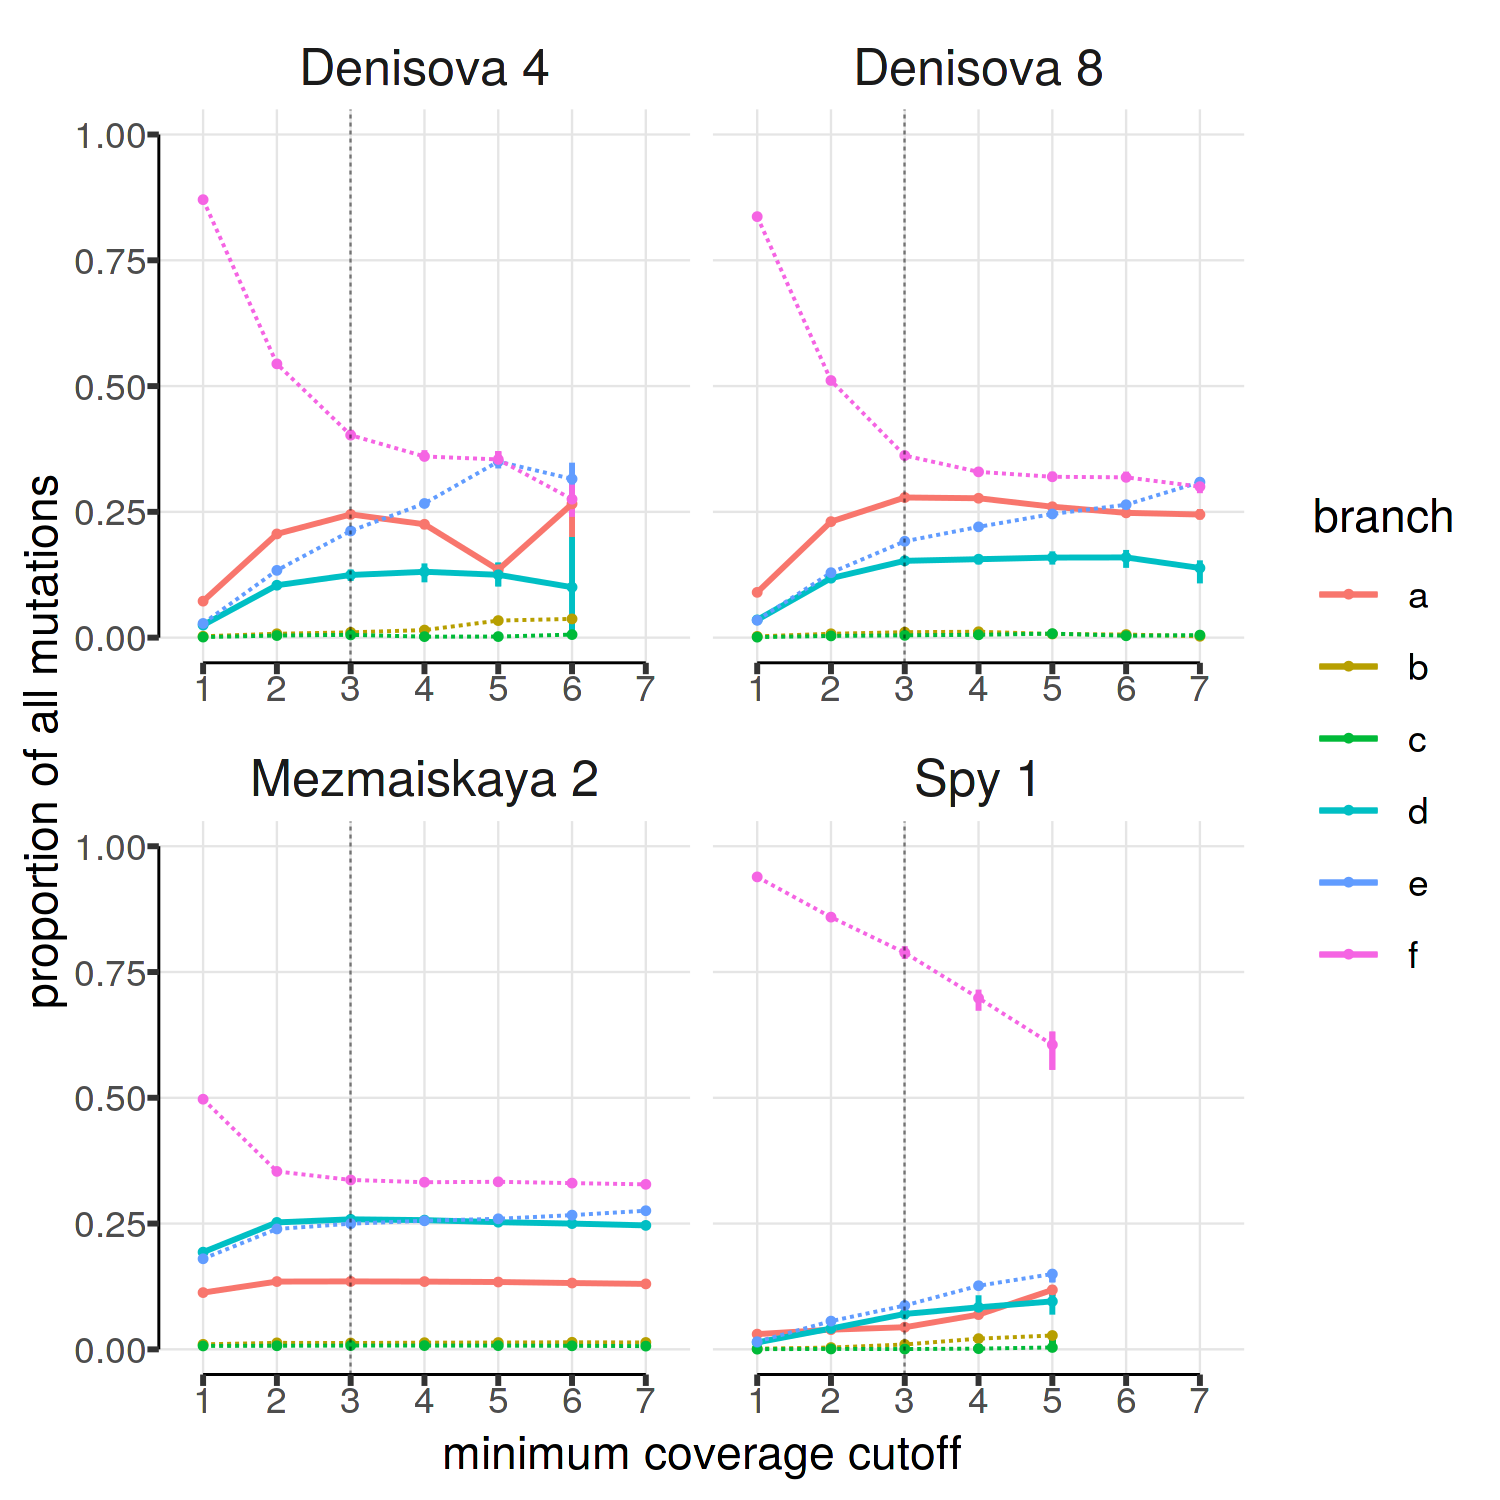

In [17]:
set_dim(5, 5)

ggplot() +
    geom_errorbar(data = inner_join(arch_branches_top, arch_branches_bottom),
                  aes(x = dp, ymin = min_prop, ymax = max_prop, color = branch), width = 0) +
    geom_line(data = filter(arch_branches, branch %in% c("a", "d")) %>%
                            group_by(arch, dp, sites, branch) %>%
                            summarise_if(is.numeric, mean),
              aes(dp, prop, color = branch, group = branch), linetype = 1) +
    geom_line(data = filter(arch_branches, !branch %in% c("a", "d")) %>%
                            group_by(arch, dp, sites, branch) %>%
                            summarise_if(is.numeric, mean),
              aes(dp, prop, color = branch, group = branch), linetype = 2, size = 1/3) +
    geom_point(data = group_by(arch_branches, arch, dp, sites, branch) %>% summarise_if(is.numeric, mean),
               aes(dp, prop, color = branch), size = 1/3) +
    geom_vline(xintercept = 3, linetype = 2, size = 1/5, alpha = 1/2, color = "black") +
    theme_bw() +
    theme(
        panel.border=element_blank(), 
        strip.text.x = element_text(size = 12),
        strip.background = element_blank(),
        axis.line = element_line(size = 1/4),
        legend.position = "right"
    ) +
    xlab("minimum coverage cutoff") +
    ylab("proportion of all mutations") +
    background_grid(major = "xy", minor = "none") +
    coord_capped_cart(ylim = c(0, 1), bottom = "both", left = "both") +
    facet_wrap(~ arch, ncol = 2, scales = "free_x") +
    guides(col = guide_legend(ncol = 1), linetype = FALSE)

ggsave(here("figures/branch_proportions_arch.png"), width = 5, height = 5)